# 04 - Clustering Archetypes

In [1]:
# Import libraries and packages
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Read in Data
df = pd.read_csv(r"/Users/emmanuel/Documents/Portfolio Projects/FA_Player_Development_Model/data/processed/Feature_Engineered.csv").drop(['Unnamed: 0'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 73 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_key_or_id        22 non-null     object 
 1   Player                  22 non-null     object 
 2   season                  22 non-null     object 
 3   Primary_Squad           22 non-null     object 
 4   Playing Time_Min        22 non-null     int64  
 5   gls_per90               22 non-null     float64
 6   ast_per90               22 non-null     float64
 7   xg_per90                22 non-null     float64
 8   xag_per90               22 non-null     float64
 9   npxg_per90              22 non-null     float64
 10  prgC_per90              22 non-null     float64
 11  prgP_per90              22 non-null     float64
 12  prgR_per90              22 non-null     float64
 13  gls_per90_t1            22 non-null     float64
 14  gls_per90_t2            22 non-null     floa

## Feature Selection for Developmental Clustering

In [3]:
# --- Define your core features ---
core_features = [
    "gls_per90", "ast_per90", "xg_per90", "xag_per90", "npxg_per90",
    "prgC_per90", "prgP_per90", "prgR_per90",
    "gls_per90_t1", "ast_per90_t1", "xg_per90_t1", "xag_per90_t1", "npxg_per90_t1",
    "prgC_per90_t1", "prgP_per90_t1", "prgR_per90_t1",
    "gls_per90_t2", "ast_per90_t2", "xg_per90_t2", "xag_per90_t2", "npxg_per90_t2",
    "prgC_per90_t2", "prgP_per90_t2", "prgR_per90_t2",
]

**Goal** : Find patterns of how wingers evolve across multiple seasons in their attacking and progression output.

I select a focused set of player-centric performance metrics that capture both productivity and involvement in ball progression, measured on a per-90-minute basis.

Each of these metrics is included for the current season, as well as for the previous two seasons (_t1, _t2) to provide a view of player development.

This allows the clustering to capture trajectories rather than single-season snapshots.

**Why exclude team-level context**

- By removing team-level variables, we ensure that clustering focuses purely on individual player performance trends, independent of tactical or environmental advantages.

In [4]:
# Keep only those present in your dataset
features = [f for f in core_features if f in df.columns]
X = df[features].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Princinple Component Analysis (retain 90% variance) ---
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced {X_scaled.shape[1]} features to {pca.n_components_} components "
      f"while retaining {sum(pca.explained_variance_ratio_):.2%} of variance.")


PCA reduced 24 features to 8 components while retaining 90.45% of variance.


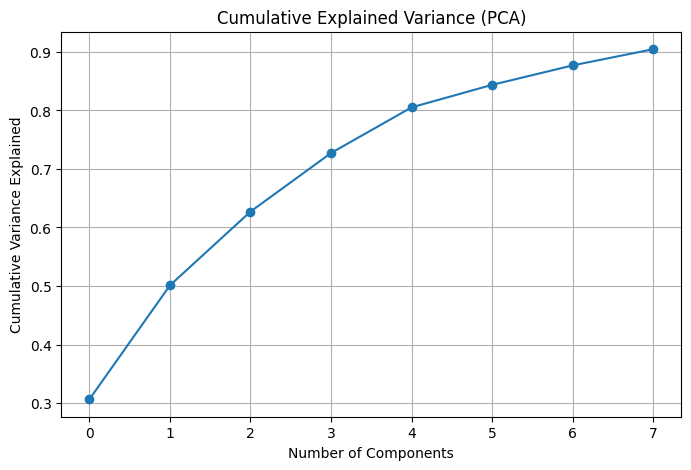

In [5]:
# Plot explained variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

In [6]:
# Create PCA DataFrame for clustering
pca_df = pd.DataFrame(
    X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
pca_df["Player"] = df["Player"]
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Player
0,0.369616,-3.046655,-2.509473,0.970761,-1.196565,-0.972362,0.071175,1.399670,Brennan Johnson
1,2.199518,-2.381580,-0.075640,-1.199772,-0.068203,-0.706250,0.067873,-0.686704,Cody Gakpo
2,-1.007475,-1.485048,-1.153173,0.808820,-0.459076,-0.812079,0.802848,-1.388997,Anthony Gordon
3,-1.787118,-1.494527,-1.669764,-0.730779,1.126209,0.609535,-2.092830,-0.013645,Dango Ouattara
4,0.813847,0.014642,2.465834,-3.132951,0.320713,0.624062,-0.627021,-0.098559,Leandro Trossard


### Principal Component Analysis (PCA) — Dimensionality Reduction

After standardising the 24 selected player performance features, I applied Principal Component Analysis (PCA) to summarise the information into a smaller number of uncorrelated components.

The plot above shows the cumulative explained variance for each principal component.

We can observe that the first few components capture most of the meaningful variation in the data:
- The first component already explains roughly 30% of the total variance, reflecting a dominant underlying trend across all metrics (for instance, overall attacking involvement).
- By the fourth component, we capture over 80% of the variance, and
- By the eighth component, we exceed our target of 90% explained variance.

By using these 8 components for clustering, we ensure that:
- Redundant or collinear features (e.g. xG, npxG, and goals) no longer distort the analysis,
- The clustering algorithm focuses on the core developmental patterns among wingers, and
- We maintain interpretability while avoiding overfitting to noise or seasonal variance.

## K-Means Clustering

In [7]:
Z = X_pca
players = df["Player"].tolist()

# 1) Sweep k and pick the best by silhouette
k_min, k_max = 2, min(10, len(df) - 1)
ks, sil_scores = [], []
for k in range(k_min, k_max + 1):
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = km.fit_predict(Z)
    sil = silhouette_score(Z, labels)
    ks.append(k)
    sil_scores.append(sil)

best_k = ks[int(np.argmax(sil_scores))]
best_sil = max(sil_scores)
print(f"Best k by silhouette: {best_k}  (score = {best_sil:.3f})")

Best k by silhouette: 3  (score = 0.183)


silhouette score (≈ 0.18) indicates moderate cluster separation not very high, but acceptable for small football datasets where styles overlap.

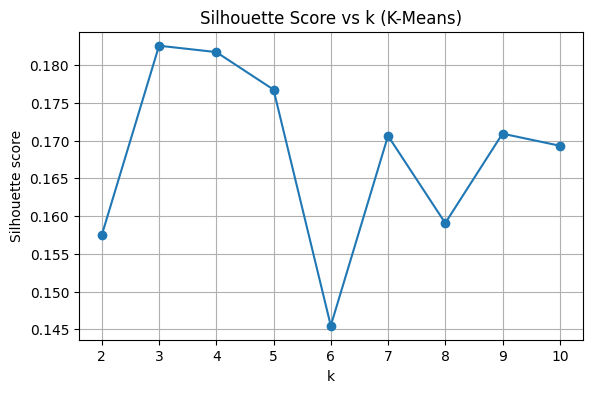

In [8]:
# 2) Plot silhouette vs k
plt.figure(figsize=(6.5,4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Score vs k (K-Means)")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

In [9]:
# Fit final K-Means with best_k
kmeans = KMeans(n_clusters=best_k, n_init=100, random_state=42)
cluster_labels = kmeans.fit_predict(Z)

df["cluster_kmeans"] = cluster_labels
print(df[["Player", "cluster_kmeans"]].sort_values("cluster_kmeans").to_string(index=False))

            Player  cluster_kmeans
Gabriel Martinelli               0
      Kaoru Mitoma               0
Alejandro Garnacho               0
      Noni Madueke               0
     Jack Grealish               0
        Cody Gakpo               1
     Mohamed Salah               1
  Leandro Trossard               1
     Harvey Barnes               1
      Bryan Mbeumo               1
        Phil Foden               1
       Bukayo Saka               1
   Brennan Johnson               2
      Jacob Murphy               2
      Harry Wilson               2
      Jarrod Bowen               2
        Pedro Neto               2
        Alex Iwobi               2
    Dango Ouattara               2
    Anthony Gordon               2
     Jack Harrison               2
     Dwight McNeil               2


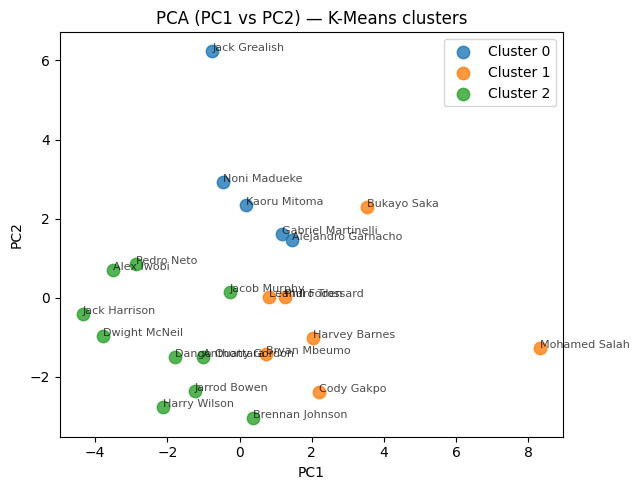

In [ ]:
# 2D PCA scatter plot
plt.figure(figsize=(6.5,5))
for c in np.unique(cluster_labels):
    m = cluster_labels == c
    plt.scatter(Z[m, 0], Z[m, 1], s=80, label=f"Cluster {c}", alpha=0.8)
for i, name in enumerate(players):
    plt.annotate(name, (Z[i, 0], Z[i, 1]), fontsize=8, alpha=0.7)
plt.title("PCA (PC1 vs PC2) — K-Means clusters")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Z-scored means
X_orig = df[features].copy()
X_z = (X_orig - X_orig.mean()) / X_orig.std(ddof=0)
cluster_summary_z = pd.concat([df[["cluster_kmeans"]], X_z], axis=1) \
                        .groupby("cluster_kmeans")[features].mean().round(2)
print("\nCluster summary (feature z-scores; 0=avg, + high, - low):")
print(cluster_summary_z)


Cluster summary (feature z-scores; 0=avg, + high, - low):
                gls_per90  ast_per90  xg_per90  xag_per90  npxg_per90  \
cluster_kmeans                                                          
0                   -0.46      -0.63      0.01      -0.45        0.20   
1                    0.78       0.48      0.59       0.53        0.41   
2                   -0.32      -0.02     -0.41      -0.15       -0.38   

                prgC_per90  prgP_per90  prgR_per90  gls_per90_t1  \
cluster_kmeans                                                     
0                     1.35       -0.11        0.87         -0.29   
1                    -0.29        0.23        0.40          1.19   
2                    -0.47       -0.11       -0.71         -0.69   

                ast_per90_t1  ...  prgP_per90_t1  prgR_per90_t1  gls_per90_t2  \
cluster_kmeans                ...                                               
0                      -0.65  ...          -0.12           1.10         

The **z-score cluster summary** translates each feature’s mean into standard deviations relative to the overall dataset.

- A positive value (> 0) means that cluster’s average is above the dataset mean → players overperform in that metric.
- A negative value (< 0) means below average → players underperform relative to peers.
- A value near 0 means they’re close to typical.

Cluster 1 is strongly positive in Goal contribution and expected metrics (current + past) consistent elite goal threat.
Cluster 0 is strongly positive in progressive carries and receives (especially across all seasons) → Dribbling, high-involvement wingers.
Cluster 2 is negative across most dimensions → supporting or transitional players with below-average attacking involvement.

### Radar Charts for K-mean clusters 


In [14]:
# Use z-score summary
cluster_profiles = cluster_summary_z.copy()

# radar features
radar_features = [
    "gls_per90", "ast_per90", "xg_per90", "xag_per90", "npxg_per90",
    "prgC_per90", "prgP_per90", "prgR_per90"
]

values = cluster_profiles[radar_features]

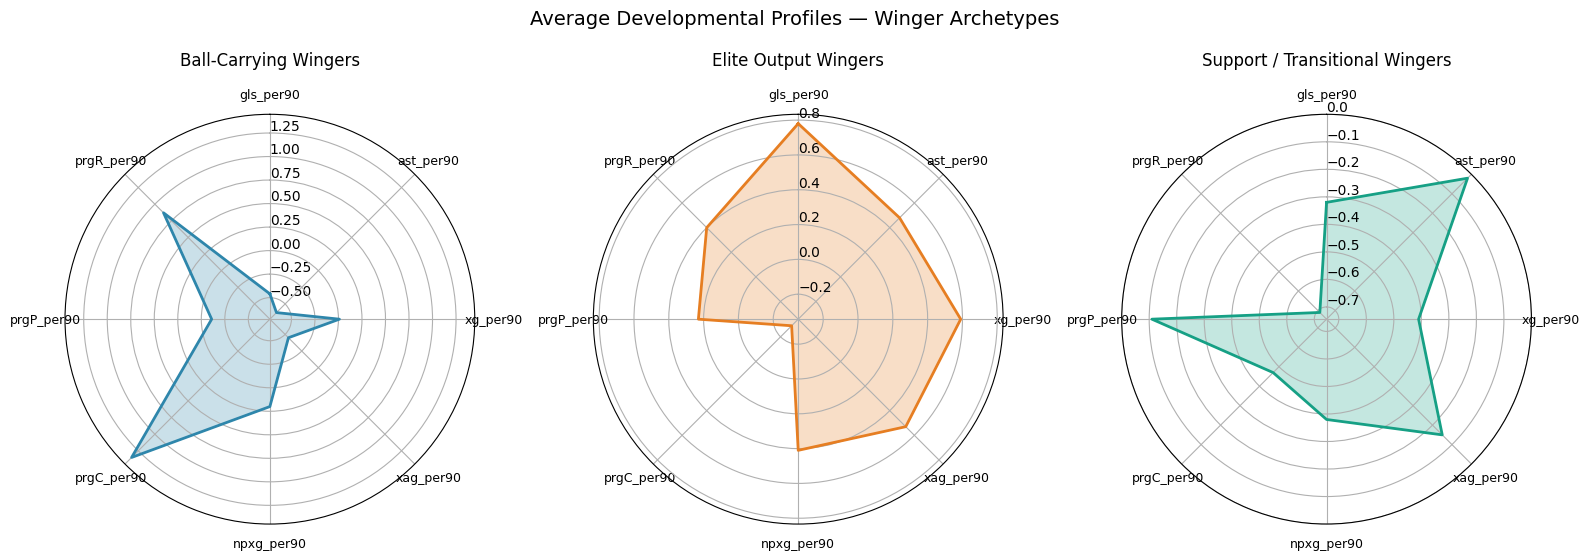

In [15]:
# --- Radar chart setup ------------------------------------------------------
def make_radar(ax, data, title, color):
    categories = list(data.index)
    N = len(categories)
    values = data.values.tolist()
    values += values[:1]  # close circle

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=9)
    ax.set_rlabel_position(0)
    ax.plot(angles, values, color=color, linewidth=2)
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_title(title, size=12, y=1.1)

# --- Create one radar per cluster ------------------------------------------
titles = {
    0: "Ball-Carrying Wingers",
    1: "Elite Output Wingers",
    2: "Support / Transitional Wingers"
}
colors = {0: "#2E86AB", 1: "#E67E22", 2: "#16A085"}

fig, axes = plt.subplots(1, 3, figsize=(16, 6), subplot_kw=dict(polar=True))
for i, (cluster, row) in enumerate(values.iterrows()):
    make_radar(
        axes[i],
        row,
        titles.get(cluster, f"Cluster {cluster}"),
        colors.get(cluster, "gray")
    )

plt.suptitle("Average Developmental Profiles — Winger Archetypes", fontsize=14)
plt.tight_layout()
plt.show()

- Elite Output Wingers (Cluster 1): Predominantly play for top-six clubs with high possession and shot volume (e.g. Salah, Saka, Foden).
- Ball-Carrying Wingers (Cluster 0): Found in both top and mid-table teams; excel in 1v1s (e.g. Madueke, Mitoma, Grealish).
- Support / Transitional Wingers (Cluster 2): Often represent mid- or lower-table clubs, fulfilling wider defensive or transition roles (e.g. Bowen, McNeil, Harrison).

The radar profiles confirm that each archetype expresses a distinct developmental identity:
- Cluster 1’s high peaks in attacking metrics indicate sustained elite end-product.
- Cluster 0’s dominance in progression metrics reflects creative ball-carrying influence.
- Cluster 2’s flatter profile suggests transitional or stabilising roles in less attacking systems.